In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import re


In [3]:
gear_df = pd.read_csv('/kaggle/input/gear_dataset.csv')

gear_df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
gear_df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,02c0,8,15,00,00,00,00,00,00,00,R
1,1.478193e+09,0350,8,05,20,44,68,77,00,00,7e,R
2,1.478193e+09,0370,8,00,20,00,00,00,00,00,00,R
3,1.478193e+09,043f,8,10,40,60,ff,78,c4,08,00,R
4,1.478193e+09,0440,8,ff,00,00,00,ff,c4,08,00,R


In [4]:
gear_df.nunique()

Timestamp    4443141
CAN ID            26
DLC                2
DATA0            150
DATA1            130
DATA2             98
DATA3             36
DATA4            221
DATA5            256
DATA6            107
DATA7            256
Flag               2
dtype: int64

In [5]:
df_2 = gear_df.copy()

In [6]:
missing_values = df_2.isnull().sum()
missing_values

Timestamp        0
CAN ID           0
DLC              0
DATA0            0
DATA1            0
DATA2            0
DATA3        40165
DATA4        40165
DATA5        40165
DATA6        40165
DATA7        40165
Flag         40165
dtype: int64

In [7]:
df_dlc_is_2 = df_2[df_2["DLC"] == 2].copy()
df_dlc_is_2.head(), df_dlc_is_2.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 52   1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 144  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 237  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 329  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 422  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 52   NaN  
 144  NaN  
 237  NaN  
 329  NaN  
 422  NaN  ,
 (40165, 12))

In [8]:
df_d2_nan = df_2[df_2["DATA2"] == 'R'].copy()
df_d2_nan.head(), df_d2_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 52   1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 144  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 237  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 329  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 422  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 52   NaN  
 144  NaN  
 237  NaN  
 329  NaN  
 422  NaN  ,
 (40165, 12))

In [9]:
df_flag_nan = df_2[(df_2["Flag"] != "T") & (df_2["Flag"] != "R")]
df_flag_nan.head(10), df_flag_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 52   1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 144  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 237  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 329  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 422  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 514  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 607  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 699  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 792  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 884  1.478193e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 52   NaN  
 144  NaN  
 237  NaN  
 329  NaN  
 422  NaN  
 514  NaN  
 607  NaN  


In [10]:
df_3 = df_2.copy()

In [11]:
# For rows with DLC=2, move 'R' from DATA2 to Flag
mask = df_3["DLC"] == 2
df_3.loc[mask, "Flag"] = df_3.loc[mask, "DATA2"]  # Copy 'R' to Flag
df_3.loc[mask, "DATA2"] = np.nan  # Set DATA2 to NaN for DLC=2



# Verify alignment
print(df_3[df_3["DLC"] == 2].head())

        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
52   1.478193e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
144  1.478193e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
237  1.478193e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
329  1.478193e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
422  1.478193e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   

    Flag  
52     R  
144    R  
237    R  
329    R  
422    R  


In [12]:
df_4 = df_3.copy()

In [13]:
# Fill NaN with hex 00
default_hex = '00'
data_columns = ['DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
df_4[data_columns] = df_4[data_columns].fillna(default_hex)
print(df_4[df_4["DLC"] == 2].head()), df_4[df_4["DLC"] == 2].shape

        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
52   1.478193e+09   05f0    2    01    00    00    00    00    00    00    00   
144  1.478193e+09   05f0    2    01    00    00    00    00    00    00    00   
237  1.478193e+09   05f0    2    01    00    00    00    00    00    00    00   
329  1.478193e+09   05f0    2    01    00    00    00    00    00    00    00   
422  1.478193e+09   05f0    2    01    00    00    00    00    00    00    00   

    Flag  
52     R  
144    R  
237    R  
329    R  
422    R  


(None, (40165, 12))

In [14]:
df_4.head(), df_4.shape

(      Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 0  1.478193e+09   02c0    8    15    00    00    00    00    00    00    00   
 1  1.478193e+09   0350    8    05    20    44    68    77    00    00    7e   
 2  1.478193e+09   0370    8    00    20    00    00    00    00    00    00   
 3  1.478193e+09   043f    8    10    40    60    ff    78    c4    08    00   
 4  1.478193e+09   0440    8    ff    00    00    00    ff    c4    08    00   
 
   Flag  
 0    R  
 1    R  
 2    R  
 3    R  
 4    R  ,
 (4443141, 12))

In [15]:
df_4[(df_4["Flag"] != "T") & (df_4["Flag"] != "R")]


,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [16]:
df_4[df_4["DATA2"] == 'R'].head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [17]:
# Drop unnecessary columns
df_drop_dlc = df_4.drop(["DLC"], axis=1).copy()
df_drop_dlc.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,02c0,15,00,00,00,00,00,00,00,R
1,1.478193e+09,0350,05,20,44,68,77,00,00,7e,R
2,1.478193e+09,0370,00,20,00,00,00,00,00,00,R
3,1.478193e+09,043f,10,40,60,ff,78,c4,08,00,R
4,1.478193e+09,0440,ff,00,00,00,ff,c4,08,00,R


In [18]:
df_drop_dlc.dtypes, df_drop_dlc.shape

(Timestamp    float64
 CAN ID        object
 DATA0         object
 DATA1         object
 DATA2         object
 DATA3         object
 DATA4         object
 DATA5         object
 DATA6         object
 DATA7         object
 Flag          object
 dtype: object,
 (4443141, 11))

In [19]:
df_can_id_0000 = df_drop_dlc[df_drop_dlc["CAN ID"] == "0000"]
df_can_id_0000.head(), df_can_id_0000.shape

(Empty DataFrame
 Columns: [Timestamp, CAN ID, DATA0, DATA1, DATA2, DATA3, DATA4, DATA5, DATA6, DATA7, Flag]
 Index: [],
 (0, 11))

In [20]:
df_6 = df_drop_dlc.copy()

df_drop_timestamp = df_drop_dlc.drop(columns=['Timestamp'], inplace=False).copy()
df_drop_timestamp.describe()



,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,4443141,4443141,4443141,4443141,4443141,4443141,4443141,4443141,4443141,4443141
unique,26,150,130,97,36,221,256,107,256,2
top,043f,00,00,00,00,00,00,00,00,R
freq,804541,1260708,1654137,2331855,1827363,1736104,1858690,2702180,2662037,3845889


In [21]:
data_columns = ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']

# Create regex pattern for valid hex
hex_pattern = r'^[0-9A-Fa-f]{2}$'

# Check for non-hex values
mask = df_6[data_columns].apply(lambda col: ~col.str.match(hex_pattern, na=False))

# Get rows with any invalid entries
invalid_rows = df_6[mask.any(axis=1)]

print("Rows with non-hex values in DATA columns:")
print(invalid_rows if not invalid_rows.empty else "No non-hex values found")

Rows with non-hex values in DATA columns:
No non-hex values found


In [22]:
df_7 = df_6.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_7.columns[1:-1]:  # Exclude 'Flag' column
    df_7[col] = df_7[col].apply(hex_to_int)

df_7.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,704,21,0,0,0,0,0,0,0,R
1,1.478193e+09,848,5,32,68,104,119,0,0,126,R
2,1.478193e+09,880,0,32,0,0,0,0,0,0,R
3,1.478193e+09,1087,16,64,96,255,120,196,8,0,R
4,1.478193e+09,1088,255,0,0,0,255,196,8,0,R


In [23]:
df_8 = df_7.copy()

In [24]:
df_8["Flag"] = df_8["Flag"].map({"R": 0, "T": 1})
df_8.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,704,21,0,0,0,0,0,0,0,0
1,1.478193e+09,848,5,32,68,104,119,0,0,126,0
2,1.478193e+09,880,0,32,0,0,0,0,0,0,0
3,1.478193e+09,1087,16,64,96,255,120,196,8,0,0
4,1.478193e+09,1088,255,0,0,0,255,196,8,0,0


In [25]:
df_8["Flag"].unique()

array([0, 1])

In [26]:
df_8.isna().sum()

Timestamp    0
CAN ID       0
DATA0        0
DATA1        0
DATA2        0
DATA3        0
DATA4        0
DATA5        0
DATA6        0
DATA7        0
Flag         0
dtype: int64

In [27]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443141 entries, 0 to 4443140
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   CAN ID     int64  
 2   DATA0      int64  
 3   DATA1      int64  
 4   DATA2      int64  
 5   DATA3      int64  
 6   DATA4      int64  
 7   DATA5      int64  
 8   DATA6      int64  
 9   DATA7      int64  
 10  Flag       int64  
dtypes: float64(1), int64(10)
memory usage: 372.9 MB


In [28]:
df_8.describe()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06,4.443141e+06
mean,1.478196e+09,7.548726e+02,5.171058e+01,4.669625e+01,4.585395e+01,8.921316e+01,5.347247e+01,5.264839e+01,2.234647e+01,3.884911e+01,1.344211e-01
std,2.771755e+03,3.743058e+02,8.907109e+01,5.107687e+01,6.045836e+01,1.085640e+02,6.911998e+01,7.394290e+01,5.294469e+01,6.638925e+01,3.411043e-01
min,1.478193e+09,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.478194e+09,3.990000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.478194e+09,7.900000e+02,5.000000e+00,3.200000e+01,0.000000e+00,2.000000e+01,1.700000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.478195e+09,1.087000e+03,3.100000e+01,6.900000e+01,9.600000e+01,2.550000e+02,1.070000e+02,1.030000e+02,9.000000e+00,5.100000e+01,0.000000e+00
max,1.478201e+09,1.680000e+03,2.550000e+02,1.920000e+02,2.520000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.090000e+02,2.550000e+02,1.000000e+00


In [29]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_8.drop(columns=['Timestamp', 'CAN ID', 'Flag']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7
DATA0,1.000000,0.156082,-0.214022,-0.273319,0.182310,0.111432,-0.093474,-0.171201
DATA1,0.156082,1.000000,0.227091,0.258177,-0.030058,0.172225,-0.282109,0.096177
DATA2,-0.214022,0.227091,1.000000,0.244652,0.372298,-0.223270,0.160775,0.031573
DATA3,-0.273319,0.258177,0.244652,1.000000,0.236899,0.258352,-0.119092,-0.150467
DATA4,0.182310,-0.030058,0.372298,0.236899,1.000000,0.036165,0.108811,-0.100664
DATA5,0.111432,0.172225,-0.223270,0.258352,0.036165,1.000000,0.075372,0.023011
DATA6,-0.093474,-0.282109,0.160775,-0.119092,0.108811,0.075372,1.000000,-0.073080
DATA7,-0.171201,0.096177,0.031573,-0.150467,-0.100664,0.023011,-0.073080,1.000000


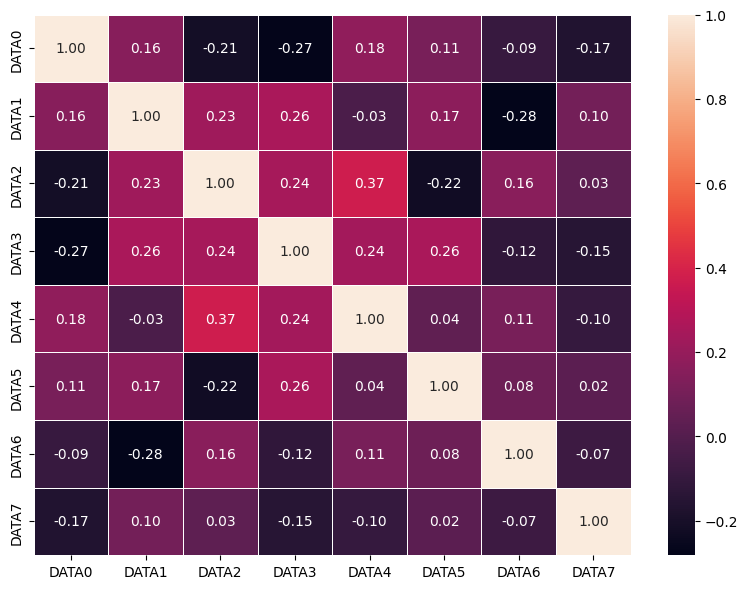

In [30]:
import os
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming 'correlation_matrix' is already computed
fig, ax = plt.subplots(figsize=(8, 6))  # Set fixed width (10) and height (8)

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5, ax=ax)

# Save the plot as a PNG image with a fixed size
plt.tight_layout()  # Ensures proper layout
plt.savefig("correlation_matrix.pdf", format="pdf", bbox_inches='tight')


# Show the plot
plt.show()



In [31]:
df_9 = df_8.copy()
df_9.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,704,21,0,0,0,0,0,0,0,0
1,1.478193e+09,848,5,32,68,104,119,0,0,126,0
2,1.478193e+09,880,0,32,0,0,0,0,0,0,0
3,1.478193e+09,1087,16,64,96,255,120,196,8,0,0
4,1.478193e+09,1088,255,0,0,0,255,196,8,0,0


# Realistic Scenario with no CAN ID included

## Algorithm Selection XGB

Accuracy: 1.0
Confusion Matrix:
 [[769178      0]
 [     0 119451]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    769178
           1       1.00      1.00      1.00    119451

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629


ROC AUC Score: 1.0000


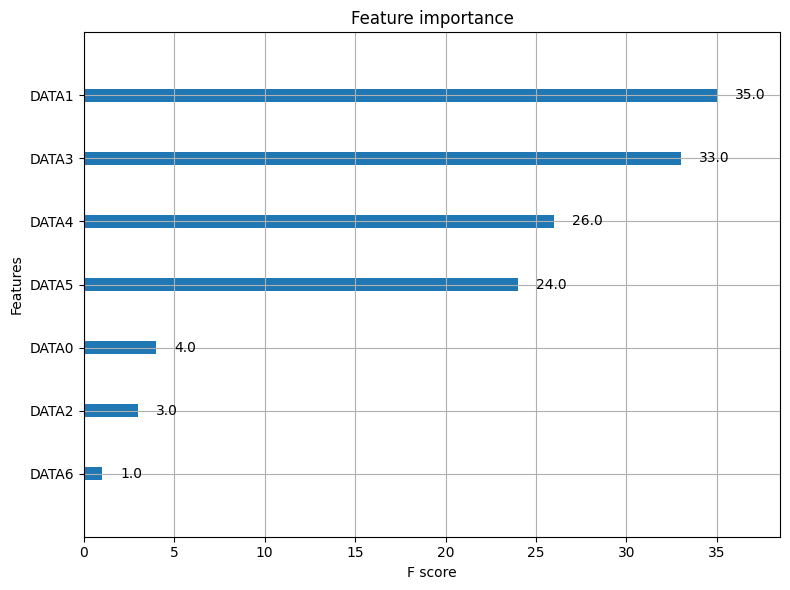

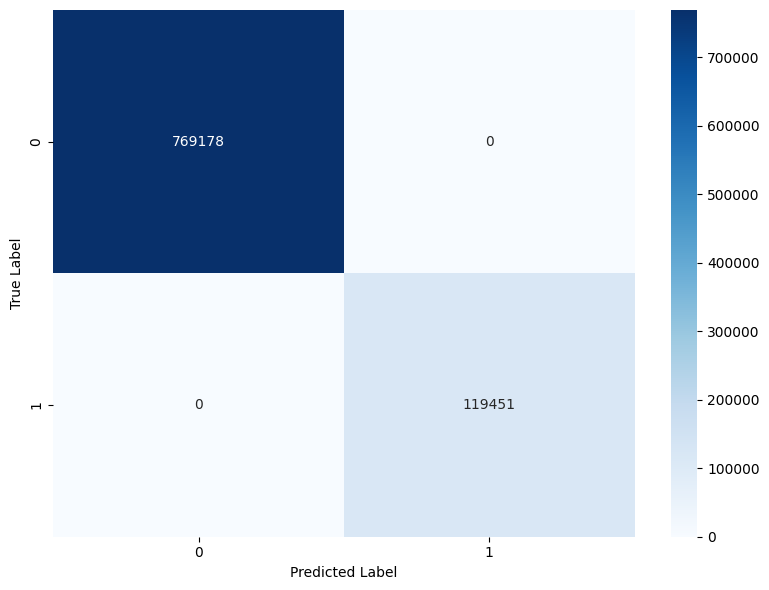

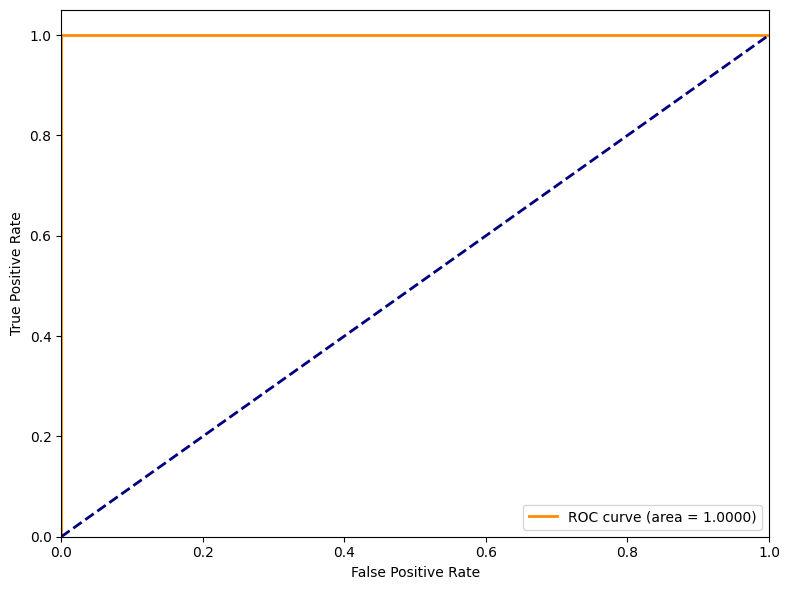

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load data
df = df_9.drop(columns=['Timestamp']).copy()

# 1. Preprocessing
# Convert CAN ID to numerical (already done as 0 for attacks)
df['CAN ID'] = df['CAN ID'].astype('int64')

# 2. Define features and target variable
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost with realistic parameters
model = xgb.XGBClassifier(
    scale_pos_weight=8,
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(model, ax=plt.gca())
plt.tight_layout()
plt.savefig(os.path.join("feature_importance_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()
# 1. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("confusion_matrix_1.pdf", format="pdf", bbox_inches='tight')
plt.show()

# 2. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve_1.pdf", format="pdf", bbox_inches='tight')

plt.show()


##  Advanced Feature Engineering

Index(['CAN ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6',
       'DATA7', 'Flag'],
      dtype='object')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    769187
           1       1.00      1.00      1.00    119442

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ROC AUC Score: 1.0000


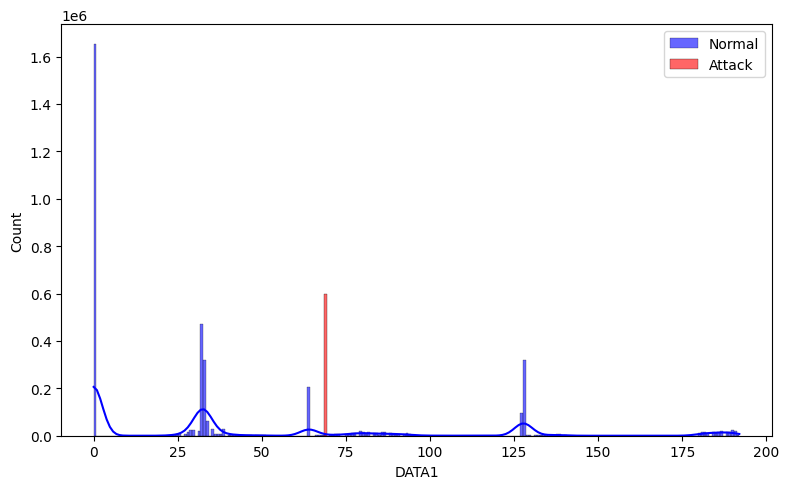

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


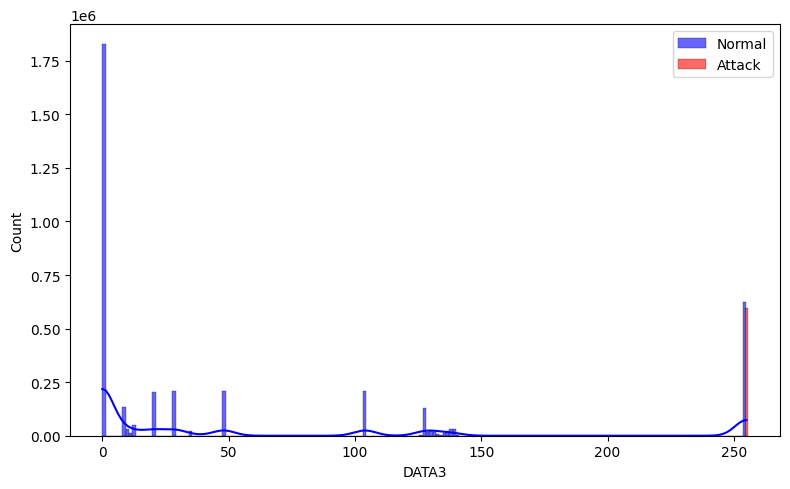

         DATA13_XOR    DATA13_SUM    DATA45_XOR
count  4.443141e+06  4.443141e+06  4.443141e+06
mean   8.816336e+01  1.359094e+02  7.945480e+01
std    7.839333e+01  1.313706e+02  7.176448e+01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  2.000000e+00
50%    7.200000e+01  9.000000e+01  7.200000e+01
75%    1.720000e+02  2.880000e+02  1.190000e+02
max    2.550000e+02  3.830000e+02  2.550000e+02
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    769187
           1       1.00      1.00      1.00    119442

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629



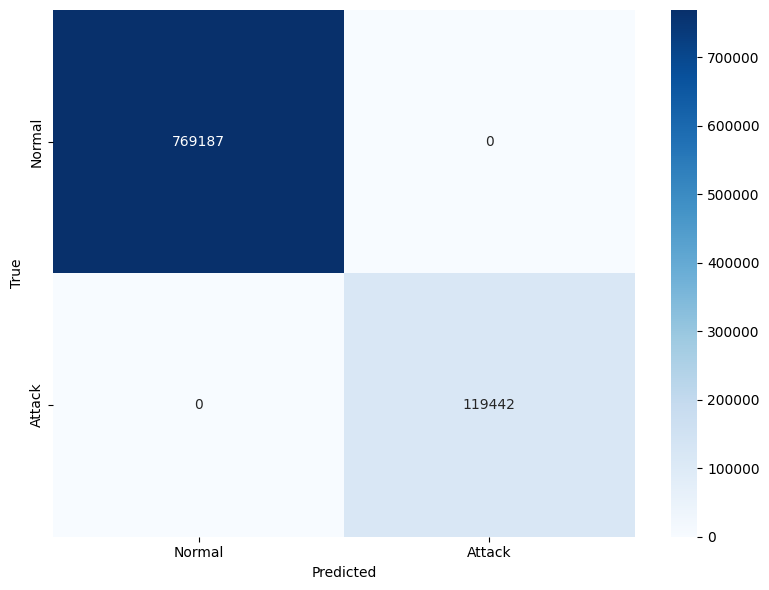

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import xgboost as xgb

# Load dataset
df = df_9.drop(columns=['Timestamp']).copy()
print(df.columns)

# Ensure numeric conversion
for col in ['DATA0', 'DATA1', 'DATA5', 'DATA7']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop NaN values if necessary
df = df.dropna(subset=['DATA0', 'DATA1', 'DATA5', 'DATA7', 'Flag'])

# Define feature columns and target
features = ['DATA1', 'DATA3', 'DATA4', 'DATA5']
X = df[features]
y = df['Flag']  # Target: 1 = Attack, 0 = Normal

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, eval_metric="logloss")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability scores

# Performance Metrics
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Precision-Recall Curve & Optimal Threshold
# precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# target_recall = 0.95
# idx = np.argmax(recall >= target_recall)
# optimal_threshold = thresholds[idx]
# print(f"Optimal Decision Threshold: {optimal_threshold:.2f}")

# best_idx = np.argmax(precision * recall)  # F1-score based tuning
# best_threshold = thresholds[best_idx]
# print(f"New Optimal Threshold: {best_threshold:.2f}")


# Function to plot distributions
def plot_distribution(feature):
    plt.figure(figsize=(8, 5))
    sns.histplot(df[df['Flag'] == 0][feature], label='Normal', color='blue', kde=True, alpha=0.6)
    sns.histplot(df[df['Flag'] == 1][feature], label='Attack', color='red', kde=True, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{feature}_distribution.pdf", format="pdf", bbox_inches='tight')
    plt.show()

# Plot distributions separately
for feature in ['DATA1', 'DATA3']:
    plot_distribution(feature)

# Feature Engineering (Bitwise & Arithmetic Transformations)
df['DATA13_XOR'] = df['DATA1'] ^ df['DATA3']
df['DATA13_SUM'] = df['DATA1'] + df['DATA3']
df['DATA45_XOR'] = df['DATA4'] ^ df['DATA5']

print(df[['DATA13_XOR', 'DATA13_SUM', 'DATA45_XOR']].describe())

# Train again with engineered features
X_new = df[['DATA1', 'DATA3', 'DATA4', 'DATA5', 'DATA13_XOR', 'DATA13_SUM', 'DATA45_XOR']]
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
model.fit(X_train_new, y_train)

# Evaluate again
y_pred_new = model.predict(X_test_new)
print(classification_report(y_test, y_pred_new))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_2.pdf", format="pdf", bbox_inches='tight')
plt.show()


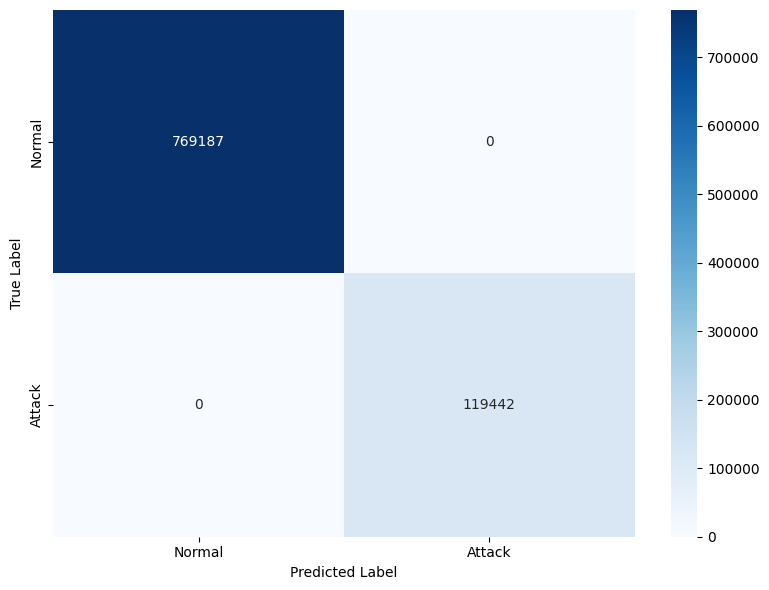

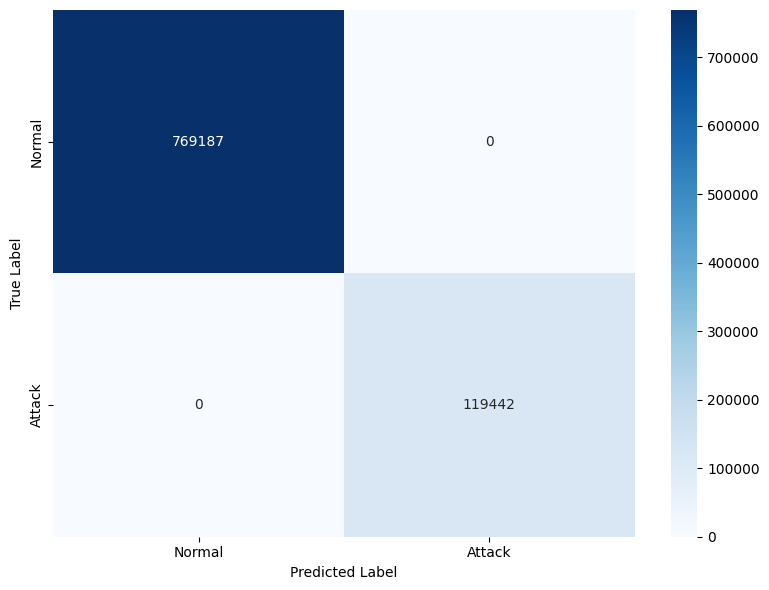

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initial Model Confusion Matrix
cm_initial = confusion_matrix(y_test, y_pred)

# Plot Initial Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_initial.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Retrained Model Confusion Matrix
cm_retrained = confusion_matrix(y_test, y_pred_new)

# Plot Retrained Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_retrained, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_retrained.pdf"), format="pdf", bbox_inches='tight')
plt.show()


In [36]:
df_9.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,704,21,0,0,0,0,0,0,0,0
1,1.478193e+09,848,5,32,68,104,119,0,0,126,0
2,1.478193e+09,880,0,32,0,0,0,0,0,0,0
3,1.478193e+09,1087,16,64,96,255,120,196,8,0,0
4,1.478193e+09,1088,255,0,0,0,255,196,8,0,0


## Temporal Features

Average Accuracy: 1.0000
Average ROC AUC Score: 1.0000

Average Confusion Matrix:
 [[3845889       0]
 [      0 3845889]]

Classification Report (Example Fold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    769178
           1       1.00      1.00      1.00    769178

    accuracy                           1.00   1538356
   macro avg       1.00      1.00      1.00   1538356
weighted avg       1.00      1.00      1.00   1538356



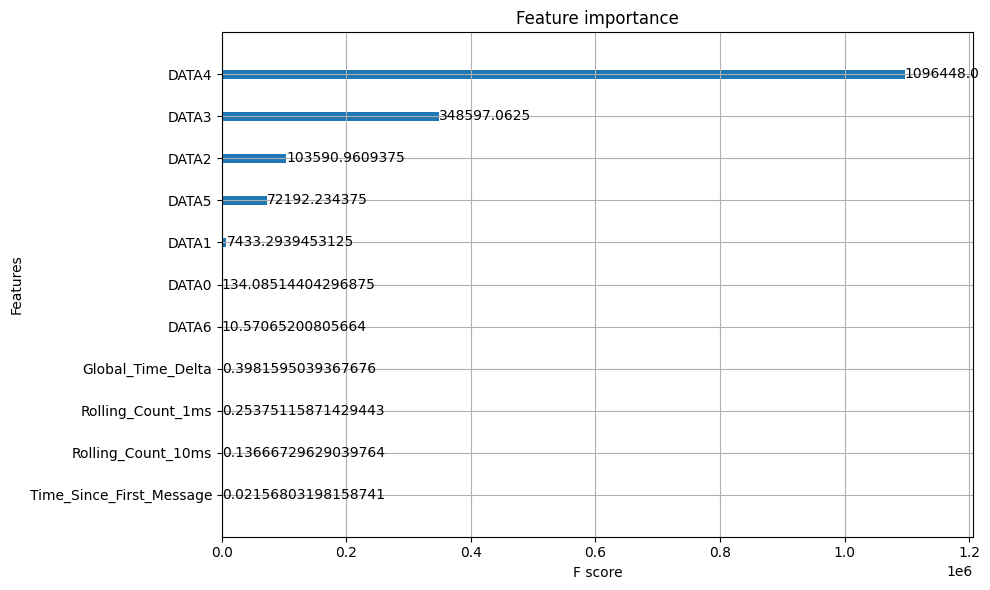

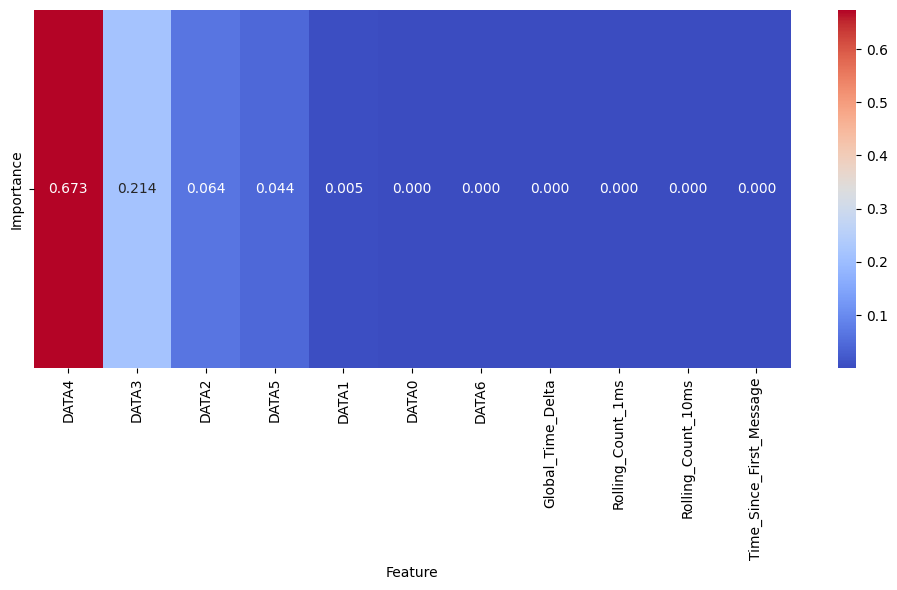

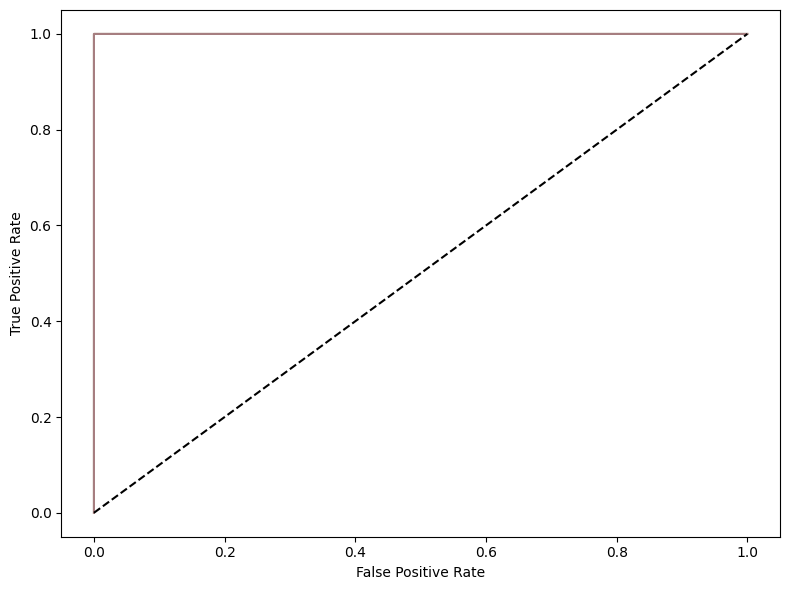

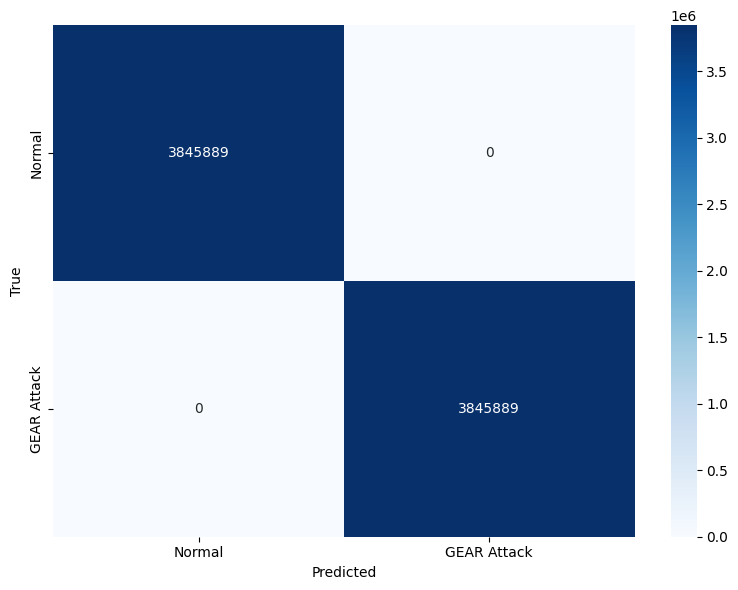

In [37]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


# Load data
df = df_9.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.sort_values('Timestamp').reset_index(drop=True)
df.set_index('Timestamp', inplace=True)

# Feature Engineering
df['Global_Time_Delta'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
df['Rolling_Count_1ms'] = df.rolling('1ms').count()['CAN ID']
df['Rolling_Count_10ms'] = df.rolling('10ms').count()['CAN ID']
df['Rolling_Count_1ms'] = df.rolling('0.3ms').count()['CAN ID']
df['Hour'] = df.index.hour
df['Time_Since_First_Message'] = (df.index - df.index.min()).total_seconds()

# Prepare features
X = df.drop(['Flag', 'CAN ID'], axis=1)
y = df['Flag']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Initialize XGBoost
model = xgb.XGBClassifier(
    scale_pos_weight=10, 
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
roc_auc_scores, accuracies, classification_reports, confusion_matrices = [], [], [], []
all_fpr, all_tpr = [], []

# Cross-validation loop
for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    classification_reports.append(classification_report(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

# Compute final averages
avg_accuracy = np.mean(accuracies)
avg_roc_auc = np.mean(roc_auc_scores)
avg_conf_matrix = np.sum(confusion_matrices, axis=0).astype(int)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average ROC AUC Score: {avg_roc_auc:.4f}")
print(f"\nAverage Confusion Matrix:\n {avg_conf_matrix}")
print("\nClassification Report (Example Fold):\n", classification_reports[0])

# Feature Importance
importances = model.get_booster().get_score(importance_type='gain')
normalized_importances = {k: v / sum(importances.values()) for k, v in importances.items()}
feature_importance_df = pd.DataFrame(list(normalized_importances.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', ax=plt.gca())
plt.tight_layout()
plt.savefig(os.path.join("feature_importance_3.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Heatmap of Feature Importance
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance_df.set_index('Feature').T, annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()
plt.savefig("feature_importance_heatmap_3.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Average ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr, alpha=0.3)  # Plot all folds
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.savefig(os.path.join("roc_curve_3.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'GEAR Attack'], yticklabels=['Normal', 'GEAR Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_3.pdf"), format="pdf", bbox_inches='tight')
plt.show()


### SMOTE applied only to training data

Average Accuracy:    1.0000
Average ROC AUC:     1.0000

Average Confusion Matrix:
[[3845889       0]
 [      0  597252]]

Classification Report (Example Fold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    769178
           1       1.00      1.00      1.00    119451

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629



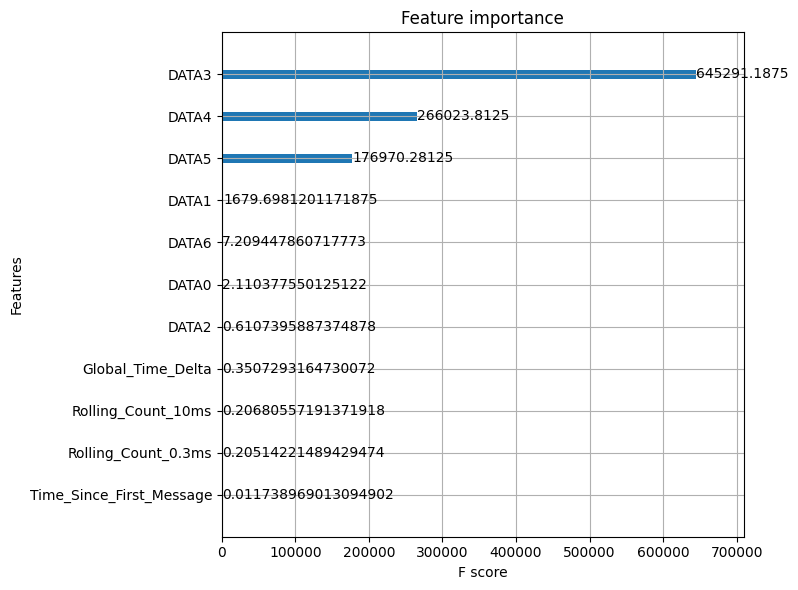

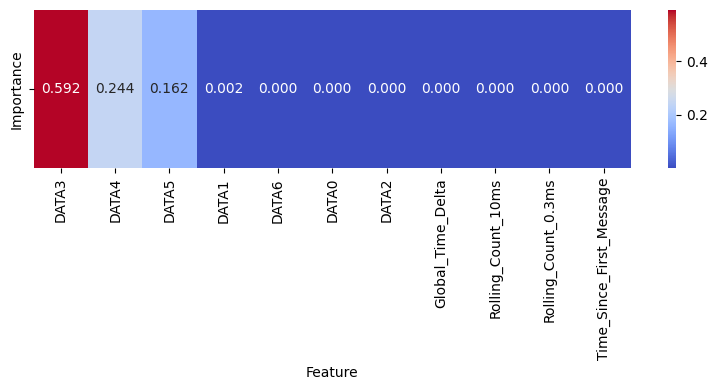

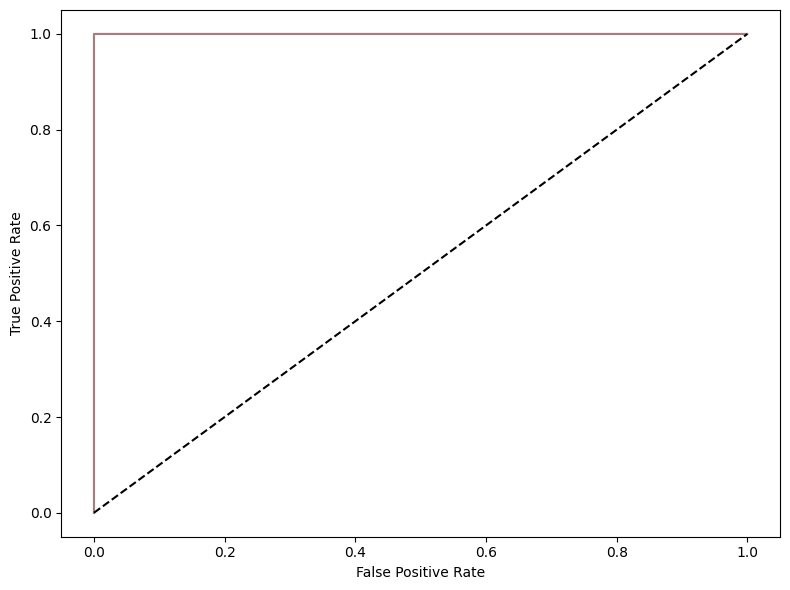

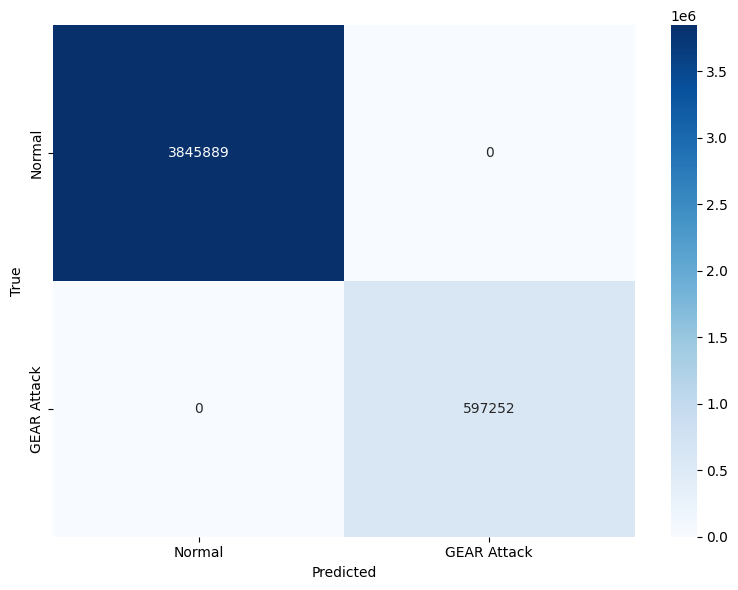

In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load and preprocess data
df = df_9.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.sort_values('Timestamp').reset_index(drop=True)
df.set_index('Timestamp', inplace=True)

# Feature Engineering
df['Global_Time_Delta'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
df['Rolling_Count_1ms']   = df.rolling('1ms').count()['CAN ID']
df['Rolling_Count_10ms']  = df.rolling('10ms').count()['CAN ID']
df['Rolling_Count_0.3ms'] = df.rolling('0.3ms').count()['CAN ID']
df['Hour']                = df.index.hour
df['Time_Since_First_Message'] = (df.index - df.index.min()).total_seconds()

# Prepare features and target
X = df.drop(['Flag', 'CAN ID'], axis=1)
y = df['Flag']

# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    scale_pos_weight=10,
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Stratified K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
accuracies = []
roc_auc_scores = []
confusion_matrices = []
all_fpr = []
all_tpr = []
classification_reports = []

# Cross-validation with SMOTE applied only on the training fold
for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE to training data only
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train and predict
    model.fit(X_train_res, y_train_res)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Collect metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

# Compute averages
avg_accuracy    = np.mean(accuracies)
avg_roc_auc     = np.mean(roc_auc_scores)
avg_conf_matrix = np.sum(confusion_matrices, axis=0).astype(int)

print(f"Average Accuracy:    {avg_accuracy:.4f}")
print(f"Average ROC AUC:     {avg_roc_auc:.4f}")
print(f"\nAverage Confusion Matrix:\n{avg_conf_matrix}")
print("\nClassification Report (Example Fold):\n", classification_reports[0])

# Plot Feature Importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(model, importance_type='gain', ax=plt.gca())
plt.tight_layout()
plt.savefig("feature_importance_gear.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Heatmap of Feature Importance
importances = model.get_booster().get_score(importance_type='gain')
norm_imp = {k: v/sum(importances.values()) for k, v in importances.items()}
fi_df = pd.DataFrame(list(norm_imp.items()), columns=['Feature','Importance']).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.heatmap(fi_df.set_index('Feature').T, annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()
plt.savefig("feature_importance_heatmap_gear.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Average ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr, alpha=0.3)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.savefig("roc_curve_gear.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','GEAR Attack'],
            yticklabels=['Normal','GEAR Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("confusion_matrix_gear_train.pdf", format="pdf", bbox_inches='tight')
plt.show()


## Updated Confusion Matrix:
```
cm = [[605815   9834]
      [    72 615578]]
```

### Explanation:
- **True Positives (TP)**: The number of instances correctly predicted as **Class 1** (attack).
  - **615578** (bottom-right cell)
  
- **False Positives (FP)**: The number of instances incorrectly predicted as **Class 1** when they are actually **Class 0** (normal).
  - **9834** (top-right cell)

- **True Negatives (TN)**: The number of instances correctly predicted as **Class 0** (normal).
  - **605815** (top-left cell)

- **False Negatives (FN)**: The number of instances incorrectly predicted as **Class 0** when they are actually **Class 1**.
  - **72** (bottom-left cell)

### Now, let's compute some key metrics:

1. **Accuracy**: The overall percentage of correct predictions.
   \[
   \text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
   \]
   \[
   \text{Accuracy} = \frac{615578 + 605815}{615578 + 9834 + 605815 + 72} = \frac{1227393}{1227399} \approx 0.99995
   \]
   **Accuracy ≈ 99.995%**

2. **Precision for Class 1 (attack)**: The percentage of predicted positive instances (Class 1) that are actually positive.
   \[
   \text{Precision (Class 1)} = \frac{TP}{TP + FP} = \frac{615578}{615578 + 9834} \approx 0.983
   \]
   **Precision (Class 1) ≈ 98.3%**

3. **Recall for Class 1 (attack)**: The percentage of actual positive instances (Class 1) that were correctly identified.
   \[
   \text{Recall (Class 1)} = \frac{TP}{TP + FN} = \frac{615578}{615578 + 72} \approx 0.99988
   \]
   **Recall (Class 1) ≈ 99.99%**

4. **F1 Score for Class 1**: The harmonic mean of precision and recall.
   \[
   \text{F1 Score (Class 1)} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \approx 2 \times \frac{0.983 \times 0.99988}{0.983 + 0.99988} \approx 0.991
   \]
   **F1 Score (Class 1) ≈ 99.1%**

5. **Precision for Class 0 (normal)**: The percentage of predicted negative instances (Class 0) that are actually negative.
   \[
   \text{Precision (Class 0)} = \frac{TN}{TN + FN} = \frac{605815}{605815 + 72} \approx 0.99988
   \]
   **Precision (Class 0) ≈ 99.99%**

6. **Recall for Class 0 (normal)**: The percentage of actual negative instances (Class 0) that were correctly identified.
   \[
   \text{Recall (Class 0)} = \frac{TN}{TN + FP} = \frac{605815}{605815 + 9834} \approx 0.984
   \]
   **Recall (Class 0) ≈ 98.4%**

7. **F1 Score for Class 0**: The harmonic mean of precision and recall for Class 0.
   \[
   \text{F1 Score (Class 0)} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \approx 2 \times \frac{0.99988 \times 0.984}{0.99988 + 0.984} \approx 0.992
   \]
   **F1 Score (Class 0) ≈ 99.2%**

### Conclusion:
- **Accuracy**: 99.995%, which suggests that the model is correct nearly 100% of the time.
- **For Class 1 (attack)**: The model performs very well with a high **precision** (98.3%) and **recall** (99.99%), making it excellent at detecting **attacks**.
- **For Class 0 (normal)**: The model also performs excellently for **normal** instances with a **precision** of 99.99% and **recall** of 98.4%.

The model appears to be performing very well overall, especially for both classes. The **attack class** (Class 1) has very few false negatives, and the **normal class** (Class 0) has very few false positives. However, you may want to look into **class imbalance**, since the numbers of instances of Class 1 and Class 0 may be quite different. But for this case, the model is performing well in distinguishing both classes.

# Algorithm RF


## Without SMOTE

Accuracy: 1.0
Confusion Matrix:
 [[769178      0]
 [     0 119451]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    769178
           1       1.00      1.00      1.00    119451

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629


ROC AUC Score: 1.0000


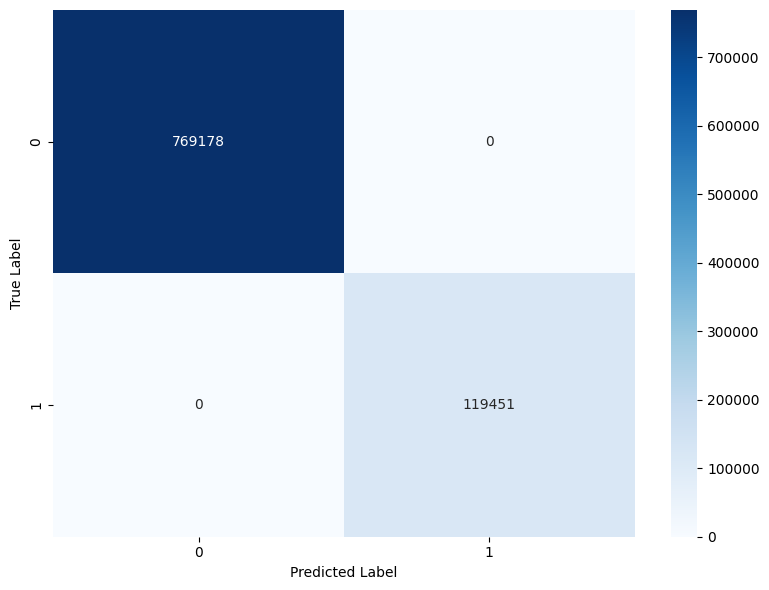

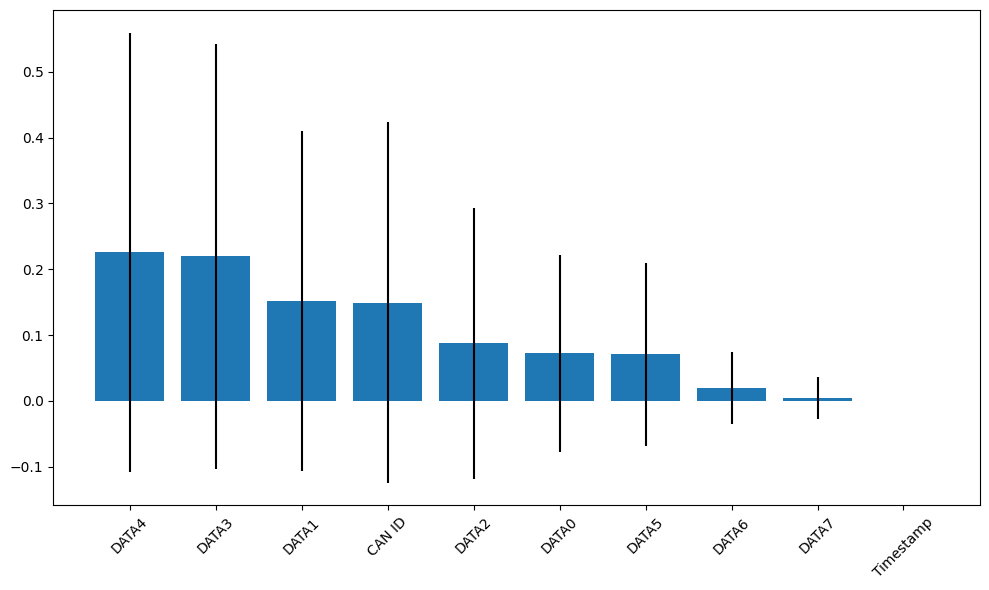

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 1. Preprocessing
# Convert CAN ID to categorical (important for tree models)
df['CAN ID'] = df['CAN ID'].astype('category')

# 2. Split data
X = df.drop('Flag', axis=1)
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Initialize Random Forest with class weighting
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all cores
    random_state=42
)

# 4. Train model
rf.fit(X_train, y_train)

# 5. Evaluate
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 6. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Plot
plt.figure(figsize=(10,6))
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join("feature_imp_rf_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()


### Class Weight Tuning

Accuracy: 1.0
Confusion Matrix:
 [[769178      0]
 [     0 119451]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    769178
           1       1.00      1.00      1.00    119451

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629


ROC AUC Score: 1.0000


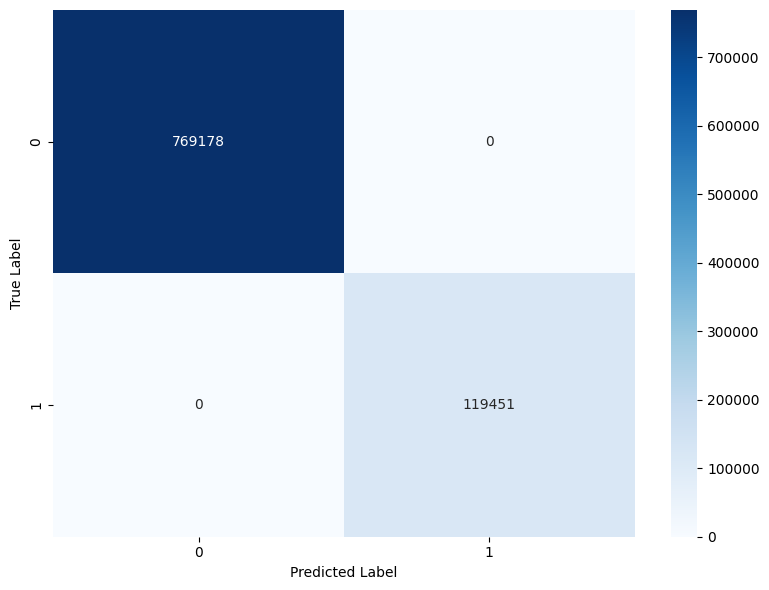

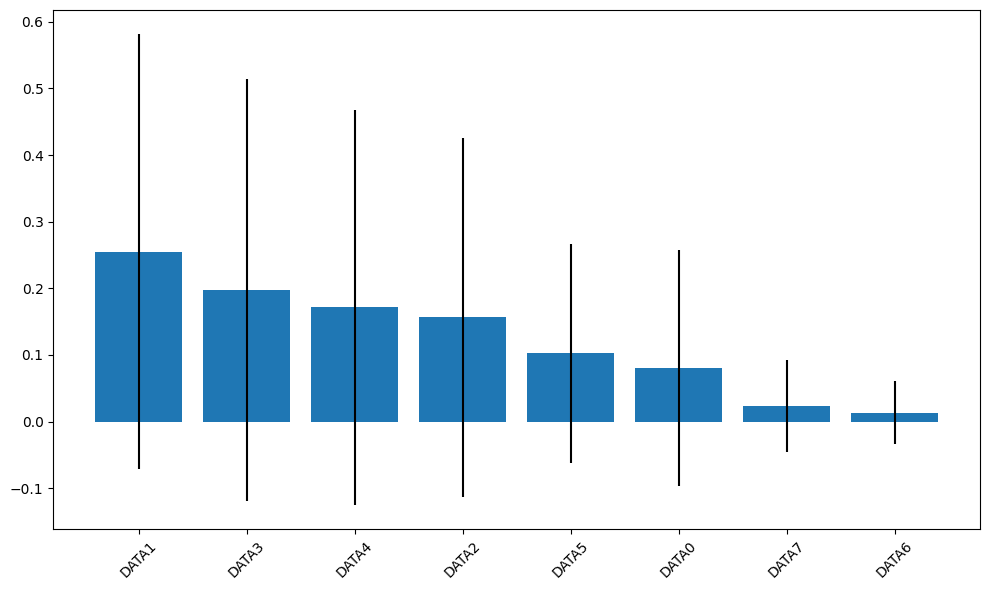

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


# 2. Split data
X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Manually calculate class weights based on the exact class ratio (~5.24:1)
# ratio = 3_078_250 / 587_521  # approximately 5.24
ratio = 10
class_weights = {0: 1, 1: ratio}  # Assign higher weight to minority class

# 4. Initialize Random Forest with manually calculated class weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # using manual weights instead of 'balanced'
    max_depth=10,                # Prevent overfitting
    n_jobs=-1,                   # Use all available cores
    random_state=42
)

# 5. Train the model
rf.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame for feature importances
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_2.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join("feature_imp_rf.pdf"), format="pdf", bbox_inches='tight')
plt.show()


## Threshold Adjustment

Optimal Threshold (based on maximum F1): 1.0000
Accuracy: 1.0
Confusion Matrix:
 [[769178      0]
 [     0 119451]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    769178
           1       1.00      1.00      1.00    119451

    accuracy                           1.00    888629
   macro avg       1.00      1.00      1.00    888629
weighted avg       1.00      1.00      1.00    888629


ROC AUC Score: 1.0000


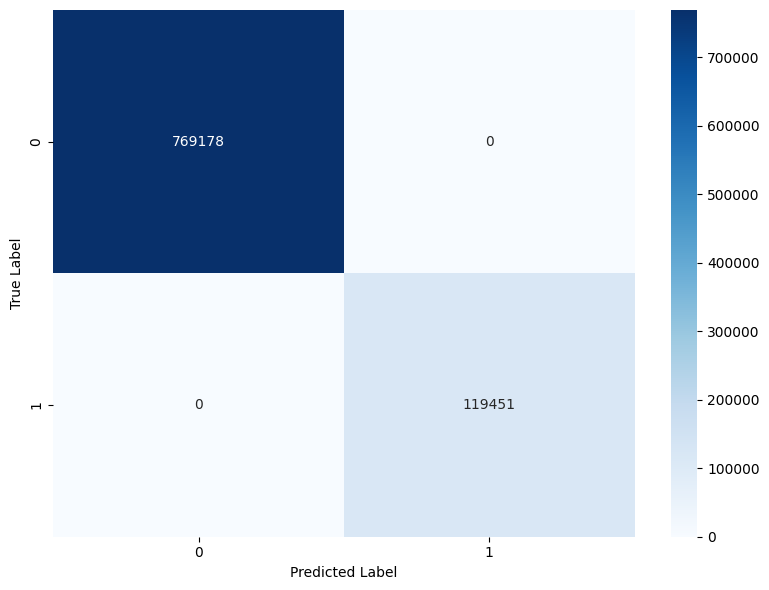

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost classifier with built-in imbalance handling
model = xgb.XGBClassifier(
    scale_pos_weight=5.24,      # Directly accounts for the class imbalance ratio
    objective='binary:logistic',
    eval_metric='aucpr',        # Optimize for precision-recall AUC
    use_label_encoder=False,    # Suppress a warning regarding label encoding
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# 7. Threshold Adjustment: Optimize decision threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for each threshold; note that thresholds array is one element shorter than precision/recall
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal Threshold (based on maximum F1): {best_threshold:.4f}")

# Use the optimal threshold to make final predictions
y_pred = (y_proba >= best_threshold).astype(int)

# 8. Evaluate the model with the adjusted threshold
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_3.pdf"), format="pdf", bbox_inches='tight')

plt.show()


## With SMOTE and KFold

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Ensure directory exists for saving plots
image_dir = "../images"
os.makedirs(image_dir, exist_ok=True)

# Load data
df = df_9.copy()

# Prepare Features and Target
X = df.drop(['Timestamp','Flag', 'CAN ID'], axis=1)  # Remove 'Flag' (target) and 'CAN ID' (identifier)
y = df['Flag']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Initialize Random Forest with Class Weighting
rf = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all CPU cores
    random_state=42
)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
roc_auc_scores, accuracies, classification_reports, confusion_matrices = [], [], [], []
all_fpr, all_tpr = [], []

# Cross-validation loop
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training set only
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train the Model on Resampled Data
    rf.fit(X_train_res, y_train_res)

    # Make predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:,1]  # Get probability of the positive class

    # Store performance metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    classification_reports.append(classification_report(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

# Compute final averages
avg_accuracy = np.mean(accuracies)
avg_roc_auc = np.mean(roc_auc_scores)
avg_conf_matrix = np.sum(confusion_matrices, axis=0).astype(int)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average ROC AUC Score: {avg_roc_auc:.4f}")
print(f"\nAverage Confusion Matrix:\n {avg_conf_matrix}")
print("\nClassification Report (Example Fold):\n", classification_reports[0])

# Average ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr, alpha=0.3)  # Plot all folds
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curve (AUC = {avg_roc_auc:.4f})')
plt.tight_layout()
plt.savefig(os.path.join("roc_curve_rf.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Average Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'GEAR Attack'], yticklabels=['Normal', 'GEAR Attack'])
plt.title('Average Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf.pdf"), format="pdf", bbox_inches='tight')
plt.show()


## SMOTE but no KFold

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE  # Import SMOTE
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 1. Prepare Features and Target
X = df.drop(['Timestamp','Flag', 'CAN ID'], axis=1)  # Remove 'Timestamp' 'Flag' (target) and 'CAN ID' (identifier)
y = df['Flag']

# 2. Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Apply SMOTE for Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_train_res)}")

# 4. Initialize Random Forest with Class Weighting
rf = RandomForestClassifier(
    n_estimators=20,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all CPU cores
    random_state=42
)

# 5. Train the Model on Resampled Data
rf.fit(X_train_res, y_train_res)

# 6. Evaluate on Test Set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]  # Get probability of the positive class

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_2.pdf"), format="pdf", bbox_inches='tight')
plt.show()


# Before SMOTE: [2462599  470017]
# After SMOTE: [2462599 2462599]
# Accuracy: 0.9766351953341317
# Confusion Matrix:
#  [[598520  17130]
#  [     0 117504]]
# Classification Report:
#                precision    recall  f1-score   support

#            0       1.00      0.97      0.99    615650
#            1       0.87      1.00      0.93    117504

#     accuracy                           0.98    733154
#    macro avg       0.94      0.99      0.96    733154
# weighted avg       0.98      0.98      0.98    733154


# SVM Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = df_9.copy()

# 1. Prepare Features and Target
X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove 'Flag' (target) and 'CAN ID' (identifier)
y = df['Flag']

# 2. Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Print class distribution before splitting
print(f"Class distribution in training set: {np.bincount(y_train)}")

# 3. Initialize SVM with Class Weighting
svm = SVC(
    kernel='rbf',            # 'linear' can be used for high-dimensional sparse data
    class_weight='balanced',  # Handle class imbalance
    probability=True,         # Enable probability estimates (needed for ROC AUC)
    random_state=42
)

# 4. Train the Model
svm.fit(X_train, y_train)

# 5. Evaluate on Test Set
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]  # Get probability of the positive class

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_svm_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()

